In [ ]:
'''
@Author: Arjun P, Tarun P
'''

In [6]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 1.0/1.0 MB 4.6 MB/s eta 0:00:00


In [7]:
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import math
from collections import Counter
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
df=pd.read_csv(r"D:\URL classifiication\URL_Model\malicious_phish.csv")

print(df.shape)
df.head()

(651191, 2)


url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement

In [10]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

## Feature Engineering

In [11]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [12]:
from urllib.parse import urlparse




def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [13]:
!pip install googlesearch-python

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 61.2/61.2 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 115.8/115.8 kB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Uninstalling beautifulsoup4-4.11.1:
      Successfully uninstalled beautifulsoup4-4.11.1
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.
conda-repo-cli 1.0.20 requires requests==2.28.1, but you have requests 2.25.1 which is incompatible.


In [14]:
df['count.'] = df['url'].apply(lambda i: i.count('.'))
df.head()

url        type  use_of_ip  \
0                                   br-icloud.com.br    phishing          0   
1                mp3raid.com/music/krizz_kaliko.html      benign          0   
2                    bopsecrets.org/rexroth/cr/1.htm      benign          0   
3  http://www.garage-pirenne.be/index.php?option=...  defacement          0   
4  http://adventure-nicaragua.net/index.php?optio...  defacement          0   

   abnormal_url  count.  
0             0       2  
1             0       2  
2             0       2  
3             1       3  
4             1       2

In [15]:
df['count-www'] = df['url'].apply(lambda i: i.count('www'))
df['count@'] = df['url'].apply(lambda i: i.count('@'))
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [16]:
df['count-https'] = df['url'].apply(lambda i : i.count('https'))
df['count-http'] = df['url'].apply(lambda i : i.count('http'))

In [17]:
df['count%'] = df['url'].apply(lambda i: i.count('%'))
df['count?'] = df['url'].apply(lambda i: i.count('?'))
df['count-'] = df['url'].apply(lambda i: i.count('-'))
df['count='] = df['url'].apply(lambda i: i.count('='))
#Length of URL
df['url_length'] = df['url'].apply(lambda i: len(str(i)))
#Hostname Length
df['hostname_length'] = df['url'].apply(lambda i: len(urlparse(i).netloc))

df.head()

url        type  use_of_ip  \
0                                   br-icloud.com.br    phishing          0   
1                mp3raid.com/music/krizz_kaliko.html      benign          0   
2                    bopsecrets.org/rexroth/cr/1.htm      benign          0   
3  http://www.garage-pirenne.be/index.php?option=...  defacement          0   
4  http://adventure-nicaragua.net/index.php?optio...  defacement          0   

   abnormal_url  count.  count-www  count@  count_dir  count_embed_domian  \
0             0       2          0       0          0                   0   
1             0       2          0       0          2                   0   
2             0       2          0       0          3                   0   
3             1       3          1       0          1                   0   
4             1       2          0       0          1                   0   

   short_url  count-https  count-http  count%  count?  count-  count=  \
0          0            0           0       0       0       1       0   
1          0            0           0       0       0       0       0   
2          0            0           0       0       0       0       0   
3          0            0           1       0       1       1       4   
4          0            0           1       0       1       1       3   

   url_length  hostname_length  
0          16                0  
1          35                0  
2          31                0  
3          88               21  
4         235               23

In [18]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

In [19]:
df.head()

url        type  use_of_ip  \
0                                   br-icloud.com.br    phishing          0   
1                mp3raid.com/music/krizz_kaliko.html      benign          0   
2                    bopsecrets.org/rexroth/cr/1.htm      benign          0   
3  http://www.garage-pirenne.be/index.php?option=...  defacement          0   
4  http://adventure-nicaragua.net/index.php?optio...  defacement          0   

   abnormal_url  count.  count-www  count@  count_dir  count_embed_domian  \
0             0       2          0       0          0                   0   
1             0       2          0       0          2                   0   
2             0       2          0       0          3                   0   
3             1       3          1       0          1                   0   
4             1       2          0       0          1                   0   

   short_url  count-https  count-http  count%  count?  count-  count=  \
0          0            0           0       0       0       1       0   
1          0            0           0       0       0       0       0   
2          0            0           0       0       0       0       0   
3          0            0           1       0       1       1       4   
4          0            0           1       0       1       1       3   

   url_length  hostname_length  sus_url  
0          16                0        0  
1          35                0        0  
2          31                0        0  
3          88               21        0  
4         235               23        0

In [20]:

!pip install tld

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     -------------------------------------- 263.8/263.8 kB 2.3 MB/s eta 0:00:00


In [21]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [22]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits']= df['url'].apply(lambda i: digit_count(i))

In [23]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters']= df['url'].apply(lambda i: letter_count(i))

In [24]:
df = df.drop("tld",1)

C:\Users\HP\AppData\Local\Temp\ipykernel_12792\2551734815.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("tld",1)


In [25]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

In [26]:
#Predictor Variables
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [28]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred))

score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

C:\Users\HP\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85621
           1       0.96      0.99      0.98     19292
           2       0.97      0.90      0.93      6504
           3       0.90      0.83      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.959


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


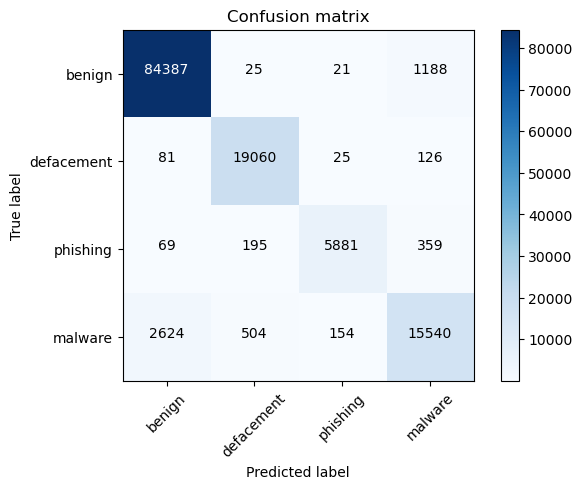

In [30]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3])
plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [31]:

lgb_feature = lgb.feature_importances_
lgb_feature

array([  28,   59, 1002,  504,   70, 1145,   46,  147,  246,  153,  253,
        220,  577,  424, 1057, 1499,  248, 1731,  639, 1178,  774])

In [50]:
lgb_features = lgb_feature.tolist()
print("HI")

HI


In [53]:
import pickle
pickle.dump(LGB_C,open('model.pkl','wb'))